In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
import keras
import numpy as np
import codecs
import csv
import string
import re
import nltk

Using TensorFlow backend.


In [0]:
data = pd.read_csv(r"./drive/My Drive/Colab/CuoiKiNLP/BaiTap/bbc-text.csv", encoding='utf-8')

In [0]:
print(data.head(5))

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


In [0]:
#verifying the dimensions of the data
data.shape

(2225, 2)

In [0]:
y = data['category']
x = data['text']

In [0]:
print(x[2])
print(y[2])

tigers wary of farrell  gamble  leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes.   we and anybody else involved in the process are still some way away from going to the next stage   tigers boss john wells told bbc radio leicester.  at the moment  there are still a lot of unknowns about andy farrell  not least his medical situation.  whoever does take him on is going to take a big  big gamble.  farrell  who has had persistent knee problems  had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game.  if he does move across to union  wells believes he would better off playing in the backs  at least initially.  i m sure he could make the step between league and union by being involved in the centre   said wells.  i th

In [0]:
#fitting the model

le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

# Defining encode and decode functions


In [0]:
def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

In [0]:
test = encode(le, ['sport','tech','business','politics'])

print(test)

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


# Specifying training and testing data

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)
sequences = tokenizer.texts_to_sequences(x)
print('Found %s unique tokens' % len(sequences))

embeddings_index = dict()
f = open(r'./drive/My Drive/Colab/CuoiKiNLP/wiki-news-300d-1M-subword.vec',encoding="utf8")
for line in f:
    values = line.split()
    #print(values)
    word = values[0]
    #print(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

29727
Found 2225 unique tokens
Loaded 999995 word vectors.


In [0]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [0]:
print(embedding_matrix.shape)

(29727, 300)


In [0]:
from keras.layers import Input, Lambda, Dense, Flatten, LSTM, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential

In [0]:
y = encode(le,y)
print(y)

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [0]:
from keras.preprocessing.sequence import pad_sequences
padded_docs = pad_sequences(sequences,maxlen=30,padding='post')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size = 0.2)

In [0]:
print(y_test)

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [0]:
print(y_train)

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [0]:
print(padded_docs[1])

[ 330   39  501   32 1743  658    9  186    2   63   68  201    4   60
  294 1272    1  214 7028 1253    5 3044 2057 2200   15   19 4863 2477
   30 7029]


In [0]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

# Specifying the metrics for training

In [0]:
with tf.Session() as session:
  model = Sequential()
  model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=30, trainable=True))  
  model.add(Conv1D(128, 5, activation='relu', input_shape=(30, 300)))
  model.add(Conv1D(256, 5, activation='relu', input_shape=(30, 128)))
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())

W0728 10:39:47.504253 139689196500864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 10:39:47.506329 139689196500864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 10:39:47.513530 139689196500864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 10:39:47.526269 139689196500864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0728 10:39:47.527050 1396891965

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           8918100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 128)           192128    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 256)           164096    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 9,275,609
Trainable params: 9,275,609
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(X_train, y_train, epochs=4, validation_split= 0.2, batch_size=16)
    model.save_weights('./text-fasttext.h5')

W0728 10:39:49.463572 139689196500864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1424 samples, validate on 356 samples
Epoch 1/4
1424/1424 [==============================] - 5s 3ms/step - loss: 1.4972 - acc: 0.3195 - val_loss: 1.0863 - val_acc: 0.5674
Epoch 2/4
1424/1424 [==============================] - 1s 664us/step - loss: 0.4949 - acc: 0.8357 - val_loss: 0.6738 - val_acc: 0.7725
Epoch 3/4
1424/1424 [==============================] - 1s 667us/step - loss: 0.0437 - acc: 0.9937 - val_loss: 0.7744 - val_acc: 0.7640
Epoch 4/4
1424/1424 [==============================] - 1s 648us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.8151 - val_acc: 0.7697


# Testing the model

In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./text-fasttext.h5')  
    predicts = model.predict(X_test, batch_size=32)

In [0]:
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline


In [0]:
y_preds = []
for preds in predicts:
  y_preds.append(np.argmax(preds))

In [0]:
y_test_1 = []
for y_t in y_test:
  y_test_1.append(np.argmax(y_t))

In [0]:
print(y_test_1)

[4, 0, 2, 0, 2, 4, 1, 0, 4, 4, 3, 3, 0, 1, 3, 1, 3, 3, 2, 0, 0, 3, 2, 0, 2, 1, 2, 3, 1, 2, 0, 0, 4, 0, 2, 1, 2, 0, 4, 1, 3, 4, 0, 3, 0, 0, 2, 4, 4, 3, 3, 1, 0, 2, 0, 0, 1, 2, 1, 4, 2, 3, 4, 1, 3, 3, 2, 1, 3, 1, 0, 0, 0, 3, 3, 4, 3, 4, 4, 0, 2, 2, 2, 4, 4, 3, 4, 3, 0, 0, 2, 3, 0, 3, 4, 0, 3, 0, 1, 3, 1, 1, 1, 0, 4, 2, 3, 4, 0, 0, 1, 3, 3, 1, 0, 1, 1, 2, 2, 0, 4, 0, 2, 0, 0, 1, 3, 0, 1, 3, 3, 4, 4, 0, 1, 0, 0, 1, 3, 0, 1, 0, 2, 3, 0, 3, 0, 0, 1, 1, 4, 0, 3, 1, 3, 1, 3, 4, 0, 4, 4, 1, 2, 2, 1, 2, 4, 2, 2, 2, 0, 4, 1, 3, 0, 3, 2, 0, 0, 3, 3, 4, 3, 0, 0, 1, 3, 2, 2, 4, 4, 0, 0, 0, 1, 3, 1, 0, 3, 0, 0, 0, 4, 0, 1, 4, 4, 4, 0, 4, 2, 1, 3, 1, 0, 0, 0, 2, 4, 1, 3, 1, 0, 3, 4, 3, 0, 4, 3, 4, 4, 2, 2, 2, 3, 4, 2, 2, 3, 0, 4, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 3, 3, 1, 2, 2, 2, 4, 3, 0, 0, 3, 0, 4, 3, 2, 3, 3, 2, 0, 4, 3, 1, 2, 0, 2, 0, 4, 2, 0, 3, 4, 3, 2, 1, 2, 4, 1, 3, 0, 2, 3, 2, 4, 0, 0, 3, 2, 3, 3, 0, 0, 1, 2, 3, 2, 3, 3, 0, 3, 3, 2, 4, 0, 0, 2, 0, 0, 1, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 

In [0]:
#Confusion matrix for trained and tested data
print(metrics.confusion_matrix(y_test_1, y_preds))

[[95  0  6  1  7]
 [11 43  7  8  4]
 [18  1 60  4  4]
 [ 9 11  0 85  3]
 [ 6  2  1  7 52]]


In [0]:
print(metrics.classification_report(y_test_1, y_preds))

              precision    recall  f1-score   support

           0       0.68      0.87      0.77       109
           1       0.75      0.59      0.66        73
           2       0.81      0.69      0.75        87
           3       0.81      0.79      0.80       108
           4       0.74      0.76      0.75        68

    accuracy                           0.75       445
   macro avg       0.76      0.74      0.74       445
weighted avg       0.76      0.75      0.75       445



# Plotting the results

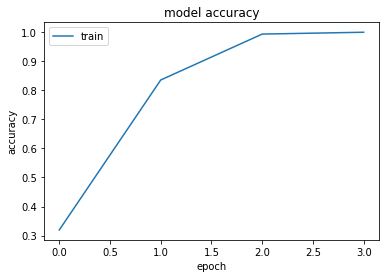

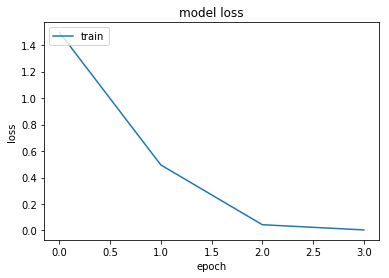

In [0]:
hist = pd.DataFrame(history.history)

# summarize history for accuracy
plt.plot(hist['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()